In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib

/tmp/ipykernel_185138/3290166092.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
weather = pd.read_csv("weather_train.csv")
temp_data = pd.DataFrame(weather.tavg)
weather.index = pd.date_range(start='2012-01-01', end='2016-12-31', freq='D')

In [3]:
temp_data.index = weather.index

In [4]:
temp_data

,tavg
2012-01-01,22.1
2012-01-02,22.3
2012-01-03,23.1
2012-01-04,23.7
2012-01-05,23.3
...,...
2016-12-27,21.4
2016-12-28,21.9
2016-12-29,20.8
2016-12-30,20.4


In [5]:
import pandas as pd
import pvlib

# Set location information (latitude, longitude, and elevation)
latitude = 12.971598
longitude = 77.594562
altitude = 920
tz = 'Asia/Kolkata'

weather_data = temp_data.tavg
times = weather_data.index
location = pvlib.location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Calculate extraterrestrial radiation
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calculate air mass, replacing NaN values with a default value (e.g., 10)
airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith']).fillna(10)

# Assuming no direct horizontal irradiance (dhi) available, set it to zero
dhi = pd.Series(0, index=times)

# Calculate the solar panel tilt and azimuth dynamically based on solar position
solar_panel_tilt = 90 - solar_position['apparent_elevation']
solar_panel_azimuth = solar_position['azimuth']

# Ensure tilt values are within a reasonable range (0 to 90 degrees)
solar_panel_tilt = solar_panel_tilt.clip(0, 90)

# Use temperature data from your CSV file
temp_air = temp_data['tavg']

# Calculate total radiation on a tilted surface with dynamic tilt and azimuth
total_irradiance_dynamic = pvlib.irradiance.get_total_irradiance(
    solar_panel_tilt, solar_panel_azimuth, solar_position['apparent_zenith'],
    solar_position['azimuth'], dni_extra, dhi, airmass)

# Convert irradiance to energy (assuming a 1 kW system)
system_size_kw = 3
energy_dynamic = total_irradiance_dynamic * 7.5 * system_size_kw/1000

# Create a pandas DataFrame to store the results
result_df_dynamic = pd.DataFrame(index=times)
result_df_dynamic['Energy_Generated_KWh'] = energy_dynamic['poa_global']
result_df_dynamic['Temperature_C'] = temp_air  # Use the existing temperature data

# Print the resulting DataFrame with dynamic tilt and azimuth
print(result_df_dynamic)

            Energy_Generated_KWh  Temperature_C
2012-01-01             30.537449           22.1
2012-01-02             30.522047           22.3
2012-01-03             30.506585           23.1
2012-01-04             30.491088           23.7
2012-01-05             30.475579           23.3
...                          ...            ...
2016-12-27             30.602058           21.4
2016-12-28             30.587086           21.9
2016-12-29             30.571941           20.8
2016-12-30             30.556649           20.4
2016-12-31             30.541234           20.0

[1827 rows x 2 columns]


In [6]:
result_df_dynamic['Energy_Generated_KWh'].max()

30.886543366447594

<Axes: >

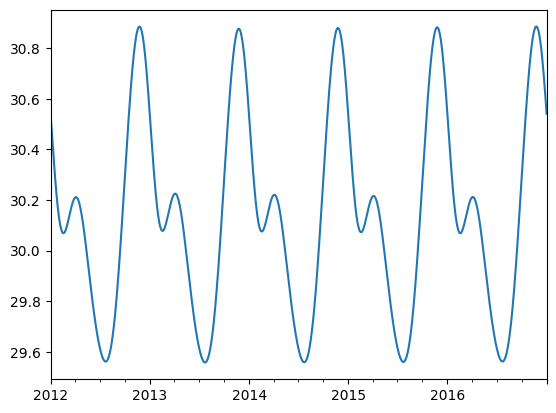

In [7]:
result_df_dynamic["Energy_Generated_KWh"].plot()

In [8]:
result_df_dynamic["Energy_Generated_KWh"] = result_df_dynamic["Energy_Generated_KWh"].shift(90).dropna()

<Axes: >

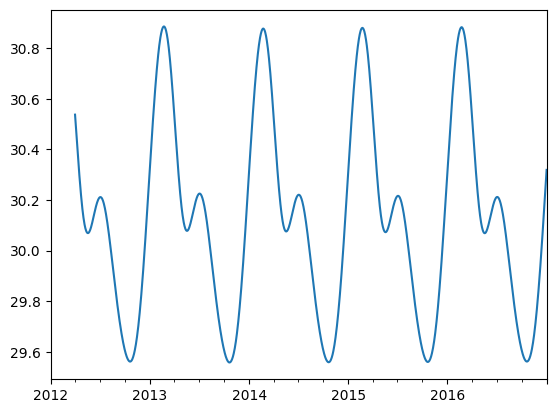

In [9]:
result_df_dynamic["Energy_Generated_KWh"].plot()

In [10]:
result_df_dynamic.dropna(inplace=True)

In [11]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2012-01-01,106.996890,106.996890,-16.996890,-16.996890,110.484688,-3.071913
2012-01-02,107.094981,107.094981,-17.094981,-17.094981,110.387431,-3.545350
2012-01-03,107.190916,107.190916,-17.190916,-17.190916,110.282394,-4.013100
2012-01-04,107.284590,107.284590,-17.284590,-17.284590,110.169622,-4.474671
2012-01-05,107.375902,107.375902,-17.375902,-17.375902,110.049165,-4.929588
...,...,...,...,...,...,...
2016-12-27,106.559524,106.559524,-16.559524,-16.559524,110.806436,-1.015076
2016-12-28,106.665553,106.665553,-16.665553,-16.665553,110.742434,-1.506922
2016-12-29,106.769985,106.769985,-16.769985,-16.769985,110.670488,-1.995738
2016-12-30,106.872695,106.872695,-16.872695,-16.872695,110.590629,-2.480913


In [12]:
total_irradiance_dynamic

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2012-01-01,1357.219962,1352.219962,5.0,5.0,0.0
2012-01-02,1356.535403,1351.535403,5.0,5.0,0.0
2012-01-03,1355.848224,1350.848224,5.0,5.0,0.0
2012-01-04,1355.159472,1350.159472,5.0,5.0,0.0
2012-01-05,1354.470185,1349.470185,5.0,5.0,0.0
...,...,...,...,...,...
2016-12-27,1360.091456,1355.091456,5.0,5.0,0.0
2016-12-28,1359.426039,1354.426039,5.0,5.0,0.0
2016-12-29,1358.752944,1353.752944,5.0,5.0,0.0
2016-12-30,1358.073282,1353.073282,5.0,5.0,0.0


noise

In [13]:



import pandas as pd
import pvlib

# Set location information (latitude, longitude, and elevation)
latitude = 12.971598
longitude = 77.594562
altitude = 920
tz = 'Asia/Kolkata'

weather_data = temp_data.tavg
times = weather_data.index
location = pvlib.location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solar_position = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Calculate extraterrestrial radiation
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calculate air mass, replacing NaN values with a default value (e.g., 10)
airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith']).fillna(10)

# Assuming no direct horizontal irradiance (dhi) available, set it to zero
dhi = pd.Series(0, index=times)

# Calculate the solar panel tilt and azimuth dynamically based on solar position
solar_panel_tilt = 90 - solar_position['apparent_elevation']
solar_panel_azimuth = solar_position['azimuth']

# Ensure tilt values are within a reasonable range (0 to 90 degrees)
solar_panel_tilt = solar_panel_tilt.clip(0, 90)

# Use temperature data from your CSV file
temp_air = temp_data['tavg']


# Generate random noise for temperature and irradiance
noise_temp = np.random.normal(0, 2, len(times))  # Adjust the parameters based on your preference
noise_irradiance = np.random.normal(0, 50, len(times))  # Adjust the parameters based on your preference

# Add noise to the temperature and irradiance variables
temp_air_with_noise = temp_air + noise_temp
total_irradiance_dynamic_with_noise = pvlib.irradiance.get_total_irradiance(
    solar_panel_tilt, solar_panel_azimuth, solar_position['apparent_zenith'],
    solar_position['azimuth'], dni_extra, dhi, airmass)['poa_global'] + noise_irradiance

# Convert irradiance to energy (assuming a 1 kW system)
system_size_kw = 3
energy_dynamic_with_noise = total_irradiance_dynamic_with_noise * 7.5 * system_size_kw / 1000

# Create a pandas DataFrame to store the results with noise
result_df_dynamic_with_noise = pd.DataFrame(index=times)
result_df_dynamic_with_noise['Energy_Generated_KWh'] = energy_dynamic_with_noise
result_df_dynamic_with_noise['Temperature_C'] = temp_air_with_noise

# Print the resulting DataFrame with noise
print(result_df_dynamic_with_noise)


            Energy_Generated_KWh  Temperature_C
2012-01-01             31.640374      22.968621
2012-01-02             30.297687      23.109223
2012-01-03             30.395406      24.785190
2012-01-04             30.523321      21.417917
2012-01-05             30.915956      23.264554
...                          ...            ...
2016-12-27             30.188292      21.408000
2016-12-28             31.541250      22.578661
2016-12-29             30.719106      21.262559
2016-12-30             29.788708      22.567946
2016-12-31             30.882089      17.542986

[1827 rows x 2 columns]


<Axes: >

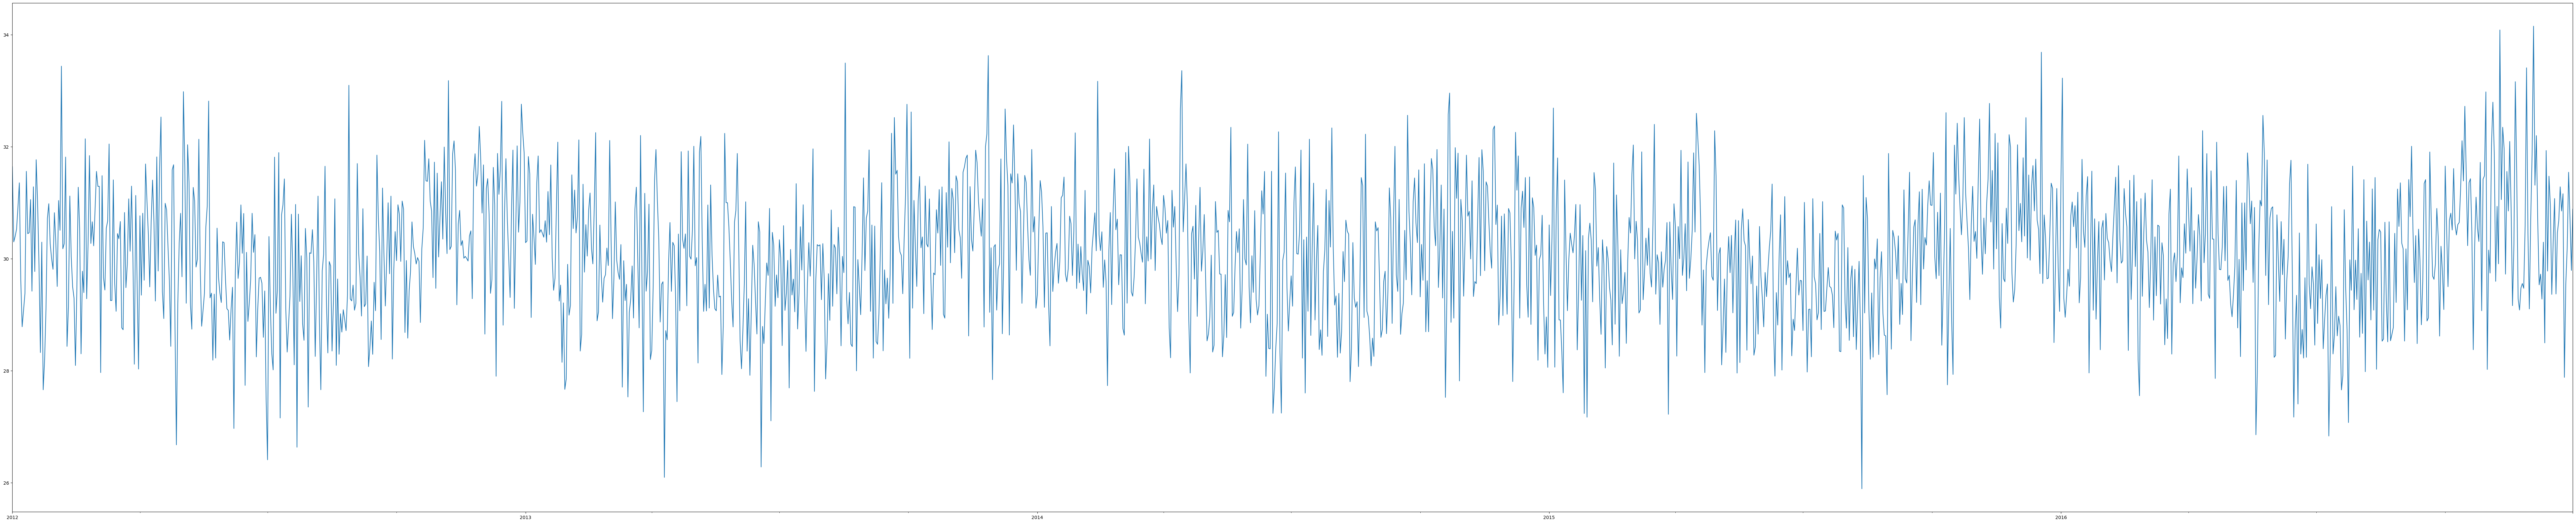

In [14]:
result_df_dynamic_with_noise['Energy_Generated_KWh'].plot(figsize=(100,20))

In [15]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2012-01-01,106.996890,106.996890,-16.996890,-16.996890,110.484688,-3.071913
2012-01-02,107.094981,107.094981,-17.094981,-17.094981,110.387431,-3.545350
2012-01-03,107.190916,107.190916,-17.190916,-17.190916,110.282394,-4.013100
2012-01-04,107.284590,107.284590,-17.284590,-17.284590,110.169622,-4.474671
2012-01-05,107.375902,107.375902,-17.375902,-17.375902,110.049165,-4.929588
...,...,...,...,...,...,...
2016-12-27,106.559524,106.559524,-16.559524,-16.559524,110.806436,-1.015076
2016-12-28,106.665553,106.665553,-16.665553,-16.665553,110.742434,-1.506922
2016-12-29,106.769985,106.769985,-16.769985,-16.769985,110.670488,-1.995738
2016-12-30,106.872695,106.872695,-16.872695,-16.872695,110.590629,-2.480913


In [16]:
total_irradiance_dynamic_with_noise, temp_air

(2012-01-01    1406.238853
 2012-01-02    1346.563878
 2012-01-03    1350.906911
 2012-01-04    1356.592031
 2012-01-05    1374.042468
                  ...     
 2016-12-27    1341.701845
 2016-12-28    1401.833314
 2016-12-29    1365.293596
 2016-12-30    1323.942593
 2016-12-31    1372.537306
 Freq: D, Name: poa_global, Length: 1827, dtype: float64,
 2012-01-01    22.1
 2012-01-02    22.3
 2012-01-03    23.1
 2012-01-04    23.7
 2012-01-05    23.3
               ... 
 2016-12-27    21.4
 2016-12-28    21.9
 2016-12-29    20.8
 2016-12-30    20.4
 2016-12-31    20.0
 Freq: D, Name: tavg, Length: 1827, dtype: float64)

In [17]:
# result_df_dynamic_with_noise + solar_position["apparent_zenith"] + solar_position["azimuth"] + total_irradiance_dynamic_with_noise
final = pd.concat([result_df_dynamic_with_noise, solar_position["apparent_zenith"], solar_position["azimuth"], total_irradiance_dynamic_with_noise], axis=1)
final

,Energy_Generated_KWh,Temperature_C,apparent_zenith,azimuth,poa_global
2012-01-01,31.640374,22.968621,106.996890,110.484688,1406.238853
2012-01-02,30.297687,23.109223,107.094981,110.387431,1346.563878
2012-01-03,30.395406,24.785190,107.190916,110.282394,1350.906911
2012-01-04,30.523321,21.417917,107.284590,110.169622,1356.592031
2012-01-05,30.915956,23.264554,107.375902,110.049165,1374.042468
...,...,...,...,...,...
2016-12-27,30.188292,21.408000,106.559524,110.806436,1341.701845
2016-12-28,31.541250,22.578661,106.665553,110.742434,1401.833314
2016-12-29,30.719106,21.262559,106.769985,110.670488,1365.293596
2016-12-30,29.788708,22.567946,106.872695,110.590629,1323.942593


In [18]:
final.to_csv("gen_train_75kwh.csv")